In [36]:
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
sys.path.append('../src/')
from utils import *
from config import *

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import seaborn as sns
rcParams.update(fig_params)

from scipy import stats as stats
from scipy.stats import rv_continuous, rv_histogram, norm, beta, multivariate_normal
from sklearn.model_selection import train_test_split
from scipy.linalg import block_diag

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data generation

### Features

Lets generate $N$ samples from 2 marginally uniformly distributed random variable $x_1, x_2$ which we make correlated via a Gaussian copula (Nelsen 2007) with correlation parameter $\rho$:

In [47]:
seed_everything(seed=42)

N = 1000
ρ = -0.9 # desired linear correlation between x1 and x2 
Σ = np.array([[1.0, ρ],  # correlation matrix
              [ρ, 1.0]])
X = multivariate_normal([0]*Σ.shape[0], Σ).rvs(size=N)
X = norm.cdf(X)

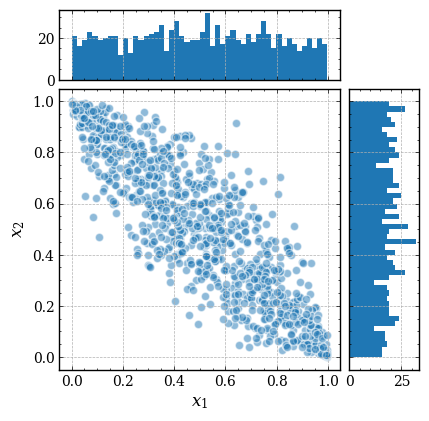

In [48]:
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=1.0, bottom=0.1, top=1.0, wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax.scatter(X[:,0], X[:,1], alpha=0.5, edgecolors='w')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histx.hist(X[:,0], bins=50)
ax_histy.hist(X[:,1], bins=50, orientation='horizontal')
plt.show()

### Target variable

Lets generate the target variable as a linear combination of the input features with additive gaussian noise:

$$
y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \epsilon
$$

with $\epsilon \sim \mathcal{N}(\mu_y=0,\sigma_y^2)$ and the $\beta$ coefficients defined below.

In [49]:
β0 = 2
β1 = 3
β2 = 4
μy = 0
σy = 1.5

β = np.array([β0, β1, β2])
X = np.hstack((np.ones((X.shape[0], 1)), X))
y = X @ β + σy * np.random.randn(N) + μy

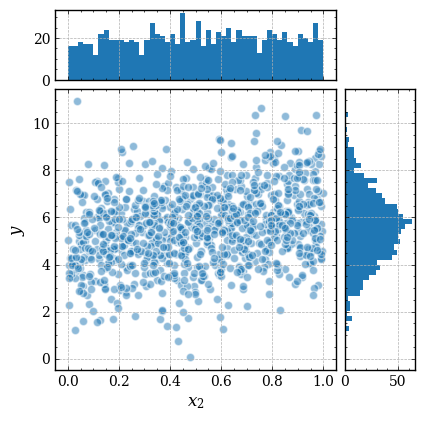

In [50]:
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=1.0, bottom=0.1, top=1.0, wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax.scatter(X[:, 2], y, alpha=0.5, edgecolors='w')
ax.set_xlabel(r'$x_2$')
ax.set_ylabel(r'$y$')
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histx.hist(X[:,2], bins=50)
ax_histy.hist(y, bins=50, orientation='horizontal')
plt.show()

## Train a linear regression model

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = LinearRegression(fit_intercept=True)
model.fit(X_train[:, 1:], y_train)
print('Estimated coefficients: ', model.coef_.round(2))
print('Estimated intercept: ', model.intercept_.round(2))

Estimated coefficients:  [3.24 4.24]
Estimated intercept:  1.78


## Simulation
### Sensitivity to correlation amount

In [52]:
N_rho = 21
ρ_low = 0.0
ρ_upper = 0.99
np.linspace(ρ_low, 1.0, N_rho).round(2)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [53]:
seed_everything(seed=42)

N_rho = 21
N_mc_sim = 1000

ρ_low = 0.0
ρ_upper = 0.99
ρs = np.linspace(ρ_low, 1.0, N_rho).round(2)
ρs[-1] = ρ_upper

df = pd.DataFrame(data=0.0, columns=['b0', 'b1', 'b2', 'mse_train', 'mse_test'], index=pd.MultiIndex.from_product([ρs, range(N_mc_sim)], names=['rho', 'exp']))

for idx, ρ in tqdm(enumerate(ρs), total=N_rho):
    
    Σ = np.array([[1.0, ρ],
                  [ρ, 1.0]])
    
    for exp in range(N_mc_sim):
        X = multivariate_normal([0]*Σ.shape[0], Σ).rvs(size=N)
        X = norm.cdf(X)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y = X @ β + σy * np.random.randn(N) + μy
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        model = LinearRegression(fit_intercept=True)
        model.fit(X_train[:, 1:], y_train)
        preds_train = model.predict(X_train[:, 1:])
        preds_test = model.predict(X_test[:, 1:])
        df.loc[(ρ, exp), 'b0'] = model.intercept_
        df.loc[(ρ, exp), 'b1'] = model.coef_[0]
        df.loc[(ρ, exp), 'b2'] = model.coef_[1]
        df.loc[(ρ, exp), 'mse_train'] = mean_squared_error(y_train, preds_train)
        df.loc[(ρ, exp), 'mse_test'] = mean_squared_error(y_test, preds_test)

  0%|          | 0/21 [00:00<?, ?it/s]

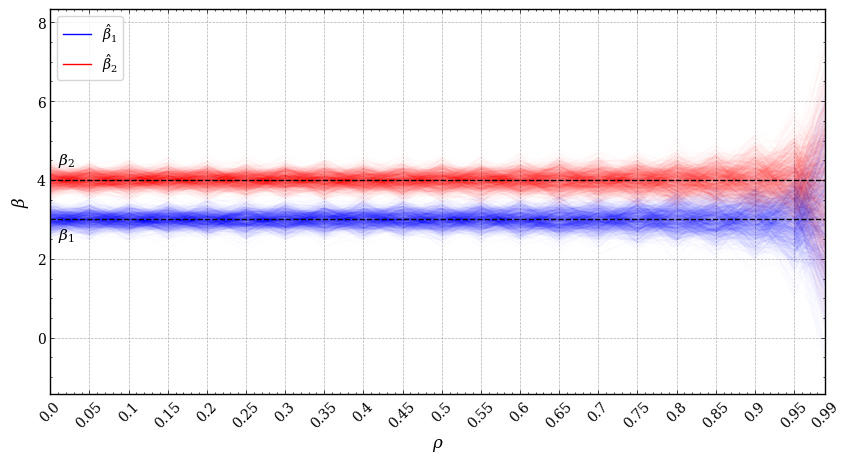

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

for exp in range(N_mc_sim):
    df_tmp = df.loc[(slice(None), exp),:].reset_index(1, drop=True).copy()
    df_tmp[['b1']].plot(color='b', linewidth=1, linestyle='-', alpha=0.01, legend='', ax=ax)
    df_tmp[['b2']].plot(color='r', linewidth=1, linestyle='-', alpha=0.01, legend='', ax=ax)

ax.axhline(β1, color='k', linestyle='--')
ax.annotate(r'$\beta_1$', xy=(0.01, β1-0.5))
ax.axhline(β2, color='k', linestyle='--')
ax.annotate(r'$\beta_2$', xy=(0.01, β2+0.4))
ax.set_xticks(ρs)
ax.set_xticklabels(ρs, rotation=45)
ax.margins(x=0)
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\beta$')
blue_line = mlines.Line2D([], [], color='b',markersize=15, label=r'$\hat{\beta}_1$')
green_line = mlines.Line2D([], [], color='r', markersize=15, label=r'$\hat{\beta}_2$')
handles = [blue_line,green_line]
labels = [h.get_label() for h in handles] 
ax.legend(handles=handles, labels=labels) 
plt.show()

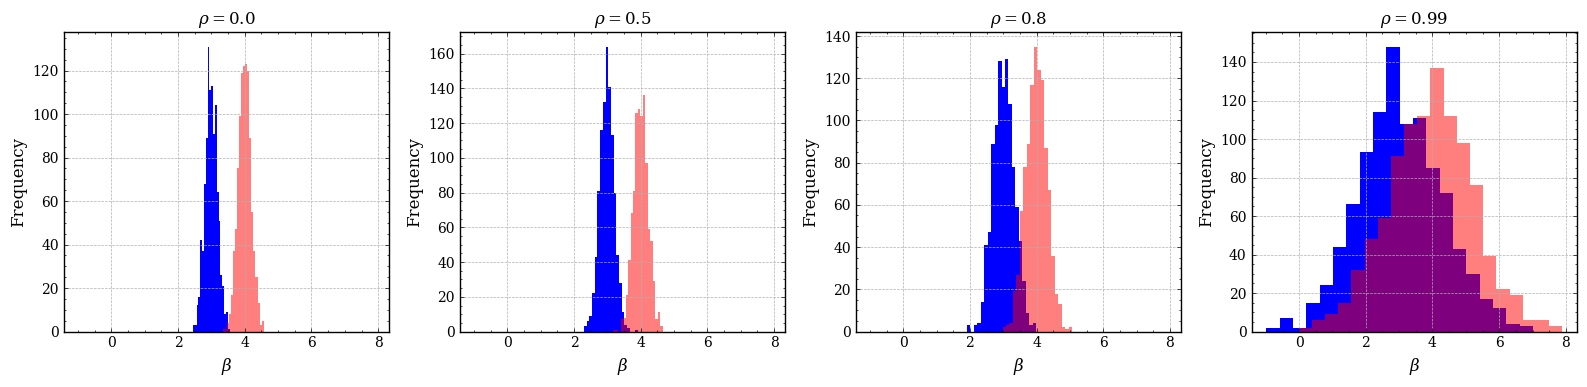

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(16,4), sharex=True)
for i, ρ in enumerate([0.0, 0.5, 0.8, 0.99]):
    df.loc[(ρ, slice(None)), 'b1'].plot.hist(ax=ax[i], color='b', bins=20)
    df.loc[(ρ, slice(None)), 'b2'].plot.hist(ax=ax[i], color='r', alpha=0.5, bins=20)
    ax[i].set_xlabel(r'$\beta$')
    ax[i].set_title(fr'$\rho={ρ}$')
plt.tight_layout()

(2.0, 2.5)

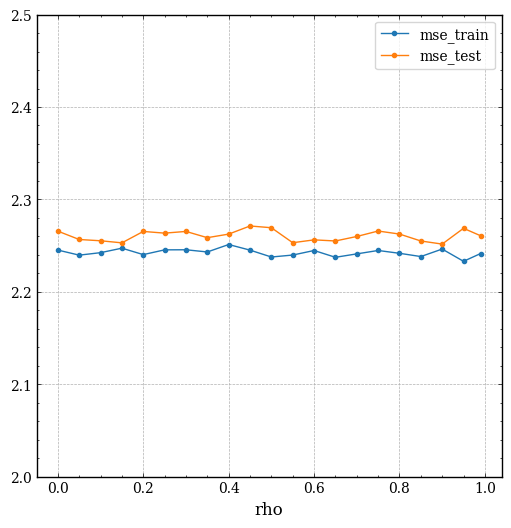

In [34]:
df.reset_index(0).reset_index(drop=True).groupby('rho')[['mse_train', 'mse_test']].mean().plot(style='.-')
plt.ylim(2,2.5)

## References

Nelsen, Roger B. An introduction to copulas. Springer Science & Business Media, 2007.